## MAML with Predefined Task Selection

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load the dataset
df = pd.read_csv('mediumload_metrics_df.csv')

# Data cleaning
df['latency'].replace('', np.nan, inplace=True)
df['latency'] = pd.to_numeric(df['latency'], errors='coerce')
data = df[(df['latency'].notna()) & (df['latency'] != 0)]

# Define IDs
baseline_priority_ids = ['baseline']
test_priority_ids = ['dropVS2AN2', 'dropVS1']
other_priority_ids = baseline_priority_ids + test_priority_ids

# Filter the DataFrame
baseline_df = data[data['priorityID'].isin(baseline_priority_ids)]
train_df = data[~data['priorityID'].isin(other_priority_ids)]
test_df = data[data['priorityID'].isin(test_priority_ids)]

# Split into features and target
X_baseline_initial_train = baseline_df.drop(columns=['latency'])
y_baseline_initial_train = baseline_df['latency']


# Predefined categories
priorityID_list = data['priorityID'].unique().tolist()
topic_list = data['topic'].unique().tolist()
app_list = data['applicationCategory'].unique().tolist()

# Columns to exclude
cat_columns = ['topic', 'applicationCategory', 'priorityID']
exclude_columns = cat_columns + ['app', 'scenario_case']

# Numerical columns
all_columns = X_baseline_initial_train.columns.tolist()
StandardSc_columns = [col for col in all_columns if col not in exclude_columns]

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), StandardSc_columns),
        ('cat', OneHotEncoder(sparse=False, drop='first', categories=[topic_list, app_list, priorityID_list]), cat_columns)
    ],
    remainder='drop'
)

# Apply transformations
X_baseline = preprocessor.fit_transform(X_baseline_initial_train)

# Fit the scaler
y_scaler = StandardScaler()
y_baseline_train_scaled = y_scaler.fit_transform(y_baseline_initial_train.values.reshape(-1, 1))

# Convert the scaled target variable back to DataFrame
y_baseline = pd.DataFrame(y_baseline_train_scaled, columns=['latency'])

# Generate tasks
tasks = []
for priority_id in train_df['priorityID'].unique():
    task_data = train_df[train_df['priorityID'] == priority_id]
    X = task_data.drop(columns=['latency'])
    y = task_data['latency']
    X_task = preprocessor.transform(X)
    y_scaled = y_scaler.transform(y.values.reshape(-1, 1))
    y_task = pd.DataFrame(y_scaled, columns=['latency'])

    tasks.append((torch.tensor(X_task, dtype=torch.float32), torch.tensor(y_task.values, dtype=torch.float32)))

# Define the model
class ComplexRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(ComplexRegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)
        self.layer2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        self.layer3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.3)
        self.layer4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout3(x)
        x = self.layer4(x)
        return x

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = X_baseline.shape[1]
model = ComplexRegressionModel(input_dim).to(device)

def meta_train(model, tasks, meta_lr, inner_lr, inner_steps, meta_steps):
    optimizer = optim.Adam(model.parameters(), lr=meta_lr)
    mse_losses = []
    mae_losses = []

    for step in range(meta_steps):
        meta_loss = 0
        mae_train_loss = 0

        for X_task, y_task in tasks:
            indices = torch.randperm(len(X_task))
            support_indices = indices[:len(X_task)//2]
            query_indices = indices[len(X_task)//2:]

            X_support, y_support = X_task[support_indices], y_task[support_indices]
            X_query, y_query = X_task[query_indices], y_task[query_indices]

            X_support, y_support = X_support.to(device), y_support.to(device)
            X_query, y_query = X_query.to(device), y_query.to(device)

            temp_model = ComplexRegressionModel(input_dim).to(device)
            temp_model.load_state_dict(model.state_dict())
            temp_optimizer = optim.SGD(temp_model.parameters(), lr=inner_lr)

            for _ in range(inner_steps):
                pred_support = temp_model(X_support)
                loss = nn.MSELoss()(pred_support, y_support)

                temp_optimizer.zero_grad()
                loss.backward()
                temp_optimizer.step()

            pred_query = temp_model(X_query)
            task_loss = nn.MSELoss()(pred_query, y_query)
            meta_loss += task_loss

            mae_task_loss = nn.L1Loss()(pred_query, y_query)
            mae_train_loss += mae_task_loss

        average_meta_loss = meta_loss / len(tasks)
        average_mae_loss = mae_train_loss / len(tasks)
        mse_losses.append(average_meta_loss.item())
        mae_losses.append(average_mae_loss.item())

        if step % 10 == 0:
            print(f'Meta Step {step}: Average MSE Meta Loss = {average_meta_loss.item()}, Average MAE Loss = {average_mae_loss.item()}')

        optimizer.zero_grad()
        average_meta_loss.backward()
        optimizer.step()

    # Save the trained model once after training
    torch.save(model.state_dict(), 'meta_trained_model.pth')
    print('Model saved to meta_trained_model.pth')

    return mse_losses, mae_losses

# Meta-train the model
mse_losses, mae_losses = meta_train(model, tasks, meta_lr=0.1, inner_lr=0.1, inner_steps=1000, meta_steps=10)

# Save results
results_df = pd.DataFrame({
    'Meta Step': range(len(mse_losses)),
    'MSE Loss': mse_losses,
    'MAE Loss': mae_losses
})
results_df.to_csv('meta_training_results.csv', index=False)

print('Meta-training results saved to meta_training_results.csv')


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Meta Step 0: Average MSE Meta Loss = 2.99387526512146, Average MAE Loss = 1.2279086112976074
Model saved to meta_trained_model.pth
Meta-training results saved to meta_training_results.csv


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

def few_shot_adaptation(model, X_val, y_val, inner_lr, inner_steps):
    # Convert to tensors
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)  # Directly convert y_val

    # Create a temporary model and optimizer for few-shot adaptation
    temp_model = ComplexRegressionModel(input_dim).to(device)
    temp_model.load_state_dict(model.state_dict())
    temp_optimizer = optim.SGD(temp_model.parameters(), lr=inner_lr)

    # Fine-tune the model with few-shot examples
    for _ in range(inner_steps):
        pred_val = temp_model(X_val_tensor)
        loss = nn.MSELoss()(pred_val, y_val_tensor)
        temp_optimizer.zero_grad()
        loss.backward()
        temp_optimizer.step()

    return temp_model

def make_predictions(model, X_test, y_test, y_scaler):
    # Convert to tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)  # Directly convert y_test

    # Make predictions
    with torch.no_grad():
        preds = model(X_test_tensor)
        mse_loss = nn.MSELoss()(preds, y_test_tensor)
        mae_loss = nn.L1Loss()(preds, y_test_tensor)

    # Convert predictions back to numpy and then to original scale
    y_pred_scaled = preds.cpu().numpy()
    y_true_scaled = y_test_tensor.cpu().numpy()

    # Inverse transform to original scale
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true = y_scaler.inverse_transform(y_true_scaled.reshape(-1, 1)).flatten()

    return y_true, y_pred, mse_loss.item(), mae_loss.item()

# Ensure you have the directory to save the adapted models
os.makedirs('adapted_models', exist_ok=True)

# Generate consistent tasks based on priorityID
tasks_val = []
for priority_id in test_df['priorityID'].unique():
    task_data_val = test_df[test_df['priorityID'] == priority_id]
    X_val = task_data_val.drop(columns=['latency'])
    y_val = task_data_val['latency']
    X_task_val = preprocessor.transform(X_val)
    y_scaled_val = y_scaler.transform(y_val.values.reshape(-1, 1))
    y_task_val = pd.DataFrame(y_scaled_val, columns=['latency'])

    tasks_val.append((torch.tensor(X_task_val, dtype=torch.float32), torch.tensor(y_task_val.values, dtype=torch.float32)))

# Load the saved meta-trained model
model = ComplexRegressionModel(input_dim).to(device)
model.load_state_dict(torch.load('meta_trained_model.pth'))
model.eval()  # Set the model to evaluation mode

# Adapt the model to each task, predict, and save results
for idx, (X_task_val, y_task_val) in enumerate(tasks_val):
    # Convert tensors back to numpy arrays for splitting
    X_task_val_np = X_task_val.numpy()
    y_task_val_np = y_task_val.numpy().flatten()

    # Split the task data into adaptation and validation sets
    X_adapt, X_val, y_adapt, y_val = train_test_split(
        X_task_val_np, y_task_val_np, test_size=0.3, random_state=42
    )

    # Perform few-shot adaptation for the current task
    adapted_model = few_shot_adaptation(model, X_adapt, y_adapt, inner_lr=0.01, inner_steps=750)

    # Save the adapted model
    adapted_model_save_path = f'adapted_models/adapted_model_task_{idx}.pth'
    torch.save(adapted_model.state_dict(), adapted_model_save_path)
    print(f'Adapted model for task {idx} saved to {adapted_model_save_path}')

    # Make predictions with the adapted model
    y_true, y_pred, test_mse_loss, test_mae_loss = make_predictions(adapted_model, X_val, y_val, y_scaler)

    # Save the prediction results to a CSV file
    results_df = pd.DataFrame({
        'Ground truth': y_true,
        'Predictions': y_pred,
        'MSE Loss': [test_mse_loss] * len(y_true),
        'MAE Loss': [test_mae_loss] * len(y_true)
    })
    results_df.to_csv(f'prediction_results_task_{idx}.csv', index=False)
    print(f'Prediction results for task {idx} saved to prediction_results_task_{idx}.csv')

    # Update the model to the adapted model for the next task
    model.load_state_dict(adapted_model.state_dict())
    model.eval()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Adapted model for task 0 saved to adapted_models/adapted_model_task_0.pth
Prediction results for task 0 saved to prediction_results_task_0.csv


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([51])) that is different to the input size (torch.Size([51, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, 

Adapted model for task 1 saved to adapted_models/adapted_model_task_1.pth
Prediction results for task 1 saved to prediction_results_task_1.csv


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


## MAML with Randomized Task Selection

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('mediumload_metrics_df.csv')

# Replace blank entries in 'latency' column with NaN (if they are blank strings)
df['latency'].replace('', np.nan, inplace=True)

# Convert 'latency' column to numeric, forcing errors to NaN
df['latency'] = pd.to_numeric(df['latency'], errors='coerce')

# Drop rows where 'latency' is NaN or 0
data = df[(df['latency'].notna()) & (df['latency'] != 0)]


# Drop rows
# data.drop(columns=['app', 'scenario_case'], inplace=True)



# Define the test priority IDs
# overloaded
# test_priority_ids = ['dropVS15AN15', 'prioEM0RT1']

#medium
test_priority_ids = ['dropVS2AN2', 'prioRTVS']

# Filter the DataFrame
test_df = data[data['priorityID'].isin(test_priority_ids)]
train_df = data[~data['priorityID'].isin(test_priority_ids)]

# #Subscribers
# test_scenario_case_ids = [80, 100]

# # # Filter the DataFrame
# test_df = data[data['scenario_case'].isin(test_scenario_case_ids)]
# train_df = data[~data['scenario_case'].isin(test_scenario_case_ids)]


# Split into features and target
X_initial_train = train_df.drop(columns=['latency'])
y_initial_train = train_df['latency']

X_initial_test = test_df.drop(columns=['latency'])
y_initial_test = test_df['latency']

# Define the predefined list of categories for each categorical feature
priorityID_list = data['priorityID'].unique().tolist()
topic_list = data['topic'].unique().tolist()
app_list = data['applicationCategory'].unique().tolist()


# List of all columns
all_columns = X_initial_train.columns.tolist()

# Columns to exclude , 'scenario_case'
cat_columns = ['topic', 'applicationCategory', 'priorityID']

others_col = ['app', 'scenario_case']

#subscribers
# others_col = ['app']

# Combine columns to exclude
exclude_columns = cat_columns + others_col

# List of columns to include (i.e., all columns except those in exclude_columns)
StandardSc_columns = [col for col in all_columns if col not in exclude_columns]


# Define the column transformer with predefined categories
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), StandardSc_columns),  # Apply scaling to numerical columns
        ('cat', OneHotEncoder(sparse=False, drop='first', categories=[topic_list, app_list, priorityID_list]), cat_columns)  # Apply one-hot encoding to categorical columns with predefined categories
    ],
    remainder='drop' #drop or passthrough
)


# Apply transformations to the training set
X_initial_train_preprocessed = preprocessor.fit_transform(X_initial_train)

# Transform the test set using the same preprocessor
X_test = preprocessor.transform(X_initial_test)

# Initialize the target scaler
y_scaler = StandardScaler()

# Fit the scaler on the initial training target and transform it
y_initial_train_scaled = y_scaler.fit_transform(y_initial_train.values.reshape(-1, 1))

# Transform the test target using the same scaler
y_initial_test_scaled = y_scaler.transform(y_initial_test.values.reshape(-1, 1))

# Convert the scaled target variable back to DataFrame for consistency
y_initial_train_scaled_df = pd.DataFrame(y_initial_train_scaled, columns=['latency'])
y_test = pd.DataFrame(y_initial_test_scaled, columns=['latency'])

# Split the preprocessed training data into final training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_initial_train_preprocessed, y_initial_train_scaled_df, test_size=0.1, random_state=42)

# Print the shape of the preprocessed datasets
print(y_test.shape)
print(X_test.shape)
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


# Define a more complex neural network model for regression
class ComplexRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(ComplexRegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)

        self.layer2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)

        self.layer3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.3)

        self.layer4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)

        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)

        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout3(x)

        x = self.layer4(x)
        return x


# Initialize the model and move it to the device
input_dim = X_initial_train_preprocessed.shape[1]  # Correctly assign input_dim
model = ComplexRegressionModel(input_dim).to(device)



def meta_train(model, tasks, meta_lr, inner_lr, inner_steps, meta_steps):
    optimizer = optim.Adam(model.parameters(), lr=meta_lr)
    mse_losses = []
    mae_losses = []

    for step in range(meta_steps):  # Outer Loop
        meta_loss = 0
        mae_train_loss = 0

        for X_task, y_task in tasks:
            indices = torch.randperm(len(X_task))
            support_indices = indices[:len(X_task)//2]
            query_indices = indices[len(X_task)//2:]

            X_support, y_support = X_task[support_indices], y_task[support_indices]
            X_query, y_query = X_task[query_indices], y_task[query_indices]

            X_support, y_support = X_support.to(device), y_support.to(device)
            X_query, y_query = X_query.to(device), y_query.to(device)

            # Create a temporary model and optimizer
            temp_model = ComplexRegressionModel(input_dim).to(device)
            temp_model.load_state_dict(model.state_dict())
            temp_optimizer = optim.SGD(temp_model.parameters(), lr=inner_lr)

            # Inner Loop: Adapt to task-specific data
            for _ in range(inner_steps):
                pred_support = temp_model(X_support)
                loss = nn.MSELoss()(pred_support, y_support)

                temp_optimizer.zero_grad()  # Zero the gradients before the backward pass
                loss.backward()  # Compute gradients
                temp_optimizer.step()  # Update parameters

            # Compute meta-loss on query set
            pred_query = temp_model(X_query)
            task_loss = nn.MSELoss()(pred_query, y_query)
            meta_loss += task_loss

            # Compute MAE loss for the task
            mae_task_loss = nn.L1Loss()(pred_query, y_query)
            mae_train_loss += mae_task_loss

        # Average the meta-loss and MAE loss across tasks
        average_meta_loss = meta_loss / len(tasks)
        average_mae_loss = mae_train_loss / len(tasks)
        mse_losses.append(average_meta_loss.item())
        mae_losses.append(average_mae_loss.item())

        # if step % 10 == 0:
        #     print(f'Meta Step {step}: Average MSE Meta Loss = {average_meta_loss.item()}, Average MAE Loss = {average_mae_loss.item()}')

        # Outer Loop: Meta-optimization step
        optimizer.zero_grad()
        average_meta_loss.backward()
        optimizer.step()

    return mse_losses, mae_losses


def update_params(model, loss, lr):
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    updated_params = []
    for param, grad in zip(model.parameters(), grads):
        updated_params.append(param - lr * grad)
    return updated_params


def generate_tasks(X, y, num_tasks, task_size):
    tasks = []
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32)
    for _ in range(num_tasks):
        indices = torch.randperm(len(X))[:task_size]
        tasks.append((X_tensor[indices], y_tensor[indices]))
    return tasks


def adapt_to_new_task(model, X_new, y_new, inner_lr, inner_steps):
    X_new, y_new = X_new.to(device), y_new.to(device)
    temp_optimizer = optim.SGD(model.parameters(), lr=inner_lr)
    for _ in range(inner_steps):  # Inner Loop: Adapt to the new task
        pred = model(X_new)
        loss = nn.MSELoss()(pred, y_new)
        temp_optimizer.zero_grad()
        loss.backward()
        temp_optimizer.step()



# Define training parameters
train_task_size_nr = X_initial_train_preprocessed.shape[0] // 5

# Generate tasks for meta-training
tasks = generate_tasks(X_initial_train_preprocessed, y_initial_train_scaled_df, num_tasks=5, task_size=train_task_size_nr)

# Meta-train the model
mse_losses, mae_losses = meta_train(model, tasks, meta_lr=0.01, inner_lr=0.01, inner_steps=500, meta_steps=200)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Meta Step': range(len(mse_losses)),
    'MSE Loss': mse_losses,
    'MAE Loss': mae_losses
})

# Save the DataFrame to a CSV file
results_df.to_csv('meta_training_results.csv', index=False)


print('Meta-training results saved to meta_training_results.csv')


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import numpy as np


# # Capture original column names for reference
# original_feature_columns = ['systemBandwidth', 'commChannelLossAN', 'commChannelLossRT',
#                             'commChannelLossTS', 'commChannelLossVS', 'brokerCapacity',
#                             'priority', 'processingRate', 'publishFrequency', 'messageSize',
#                             'topic', 'applicationCategory', 'priorityID']



# Capture original column names for reference
original_feature_columns = StandardSc_columns + cat_columns

# Map the transformed column names back to original column names
feature_names = preprocessor.get_feature_names_out()


# Function to reverse one-hot encoding
def reverse_one_hot_encoding(X, encoder):
    # Get the feature names
    feature_names = encoder.get_feature_names_out()
    # Retrieve categorical column indices
    cat_col_indices = [i for i in range(len(feature_names)) if feature_names[i].startswith('topic') or
                                                           feature_names[i].startswith('applicationCategory') or
                                                           feature_names[i].startswith('priorityID')]
    # Get the one-hot encoded data
    one_hot_data = X[:, cat_col_indices]
    # Reverse the one-hot encoding
    cat_data = encoder.inverse_transform(one_hot_data)
    # Replace one-hot encoded columns with original categorical columns
    X_reversed = np.hstack((X[:, :len(feature_names) - len(cat_col_indices)], cat_data))
    return X_reversed

# Define subsets to iterate over
# subsets = [
#     (X_test[:15], y_test.iloc[:15]),
#     (X_test[:30], y_test.iloc[:30]),
#     (X_test[:45], y_test.iloc[:45])
# ]

# Define subsets to iterate over
subsets = [
    (X_test, y_test)
]

# Loop over each subset
for i, (X_subset, y_subset) in enumerate(subsets):
    # Define task size
    test_task_size_nr = X_subset.shape[0] // 1

    # Generate a new task for testing
    X_new, y_new = generate_tasks(X_subset, y_subset, num_tasks=1, task_size=test_task_size_nr)[0]

    # Adapt the model to the new task
    adapt_to_new_task(model, X_new, y_new, inner_lr=0.01, inner_steps=500)

    # Evaluate the adapted model
    with torch.no_grad():
        X_initial_test_tensor = torch.tensor(X_subset, dtype=torch.float32).to(device)
        y_initial_test_tensor = torch.tensor(y_subset.values, dtype=torch.float32).to(device)
        pred = model(X_initial_test_tensor)

        # Calculate losses
        test_mse_loss = nn.MSELoss()(pred, y_initial_test_tensor)
        test_mae_loss = nn.L1Loss()(pred, y_initial_test_tensor)

        # Convert tensors to numpy arrays
        X_numpy = X_subset
        y_true_scaled = y_initial_test_tensor.cpu().numpy()
        y_pred_scaled = pred.cpu().numpy()

        # Descale the predicted and Ground truth
        y_true = y_scaler.inverse_transform(y_true_scaled.reshape(-1, 1)).flatten()
        y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

        # Reverse one-hot encoding for X
        X_reversed = reverse_one_hot_encoding(X_numpy, preprocessor.named_transformers_['cat'])

        # Create DataFrame for the current subset with transformed feature names
        subset_df = pd.DataFrame(X_reversed, columns=[f'Feature_{j}' for j in range(X_reversed.shape[1])])
        subset_df['Ground truth'] = y_true
        subset_df['Predictions'] = y_pred
        subset_df['MSE Loss'] = test_mse_loss.item()
        subset_df['MAE Loss'] = test_mae_loss.item()
        subset_df['Index'] = range(len(y_true))

        # Save DataFrame to CSV
        filename = f'subset_MAML_{i+1}_results.csv'
        subset_df.to_csv(filename, index=False)
        print(f'Results for Subset {i+1} saved to {filename}')


Results for Subset 1 saved to subset_MAML_1_results.csv


In [ ]:
#####splitting dataset adaptation

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming device is defined somewhere
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def adapt_to_new_task(model, X_new, y_new, inner_lr, inner_steps):
    X_new, y_new = X_new.to(device), y_new.to(device)
    temp_optimizer = optim.SGD(model.parameters(), lr=inner_lr)
    for _ in range(inner_steps):  # Inner Loop: Adapt to the new task
        pred = model(X_new)
        loss = nn.MSELoss()(pred, y_new)
        temp_optimizer.zero_grad()
        loss.backward()
        temp_optimizer.step()

# Define function for reversing one-hot encoding
def reverse_one_hot_encoding(X, encoder):
    feature_names = encoder.get_feature_names_out()
    cat_col_indices = [i for i in range(len(feature_names)) if feature_names[i].startswith('topic') or
                                                           feature_names[i].startswith('applicationCategory') or
                                                           feature_names[i].startswith('priorityID')]
    one_hot_data = X[:, cat_col_indices]
    cat_data = encoder.inverse_transform(one_hot_data)
    X_reversed = np.hstack((X[:, :len(feature_names) - len(cat_col_indices)], cat_data))
    return X_reversed

# Define subsets to iterate over
subsets = [
    (X_test, y_test)
]

# Loop over each subset
for i, (X_subset, y_subset) in enumerate(subsets):
    # Randomly split the subset into 30% for adaptation and 70% for prediction
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.5, random_state=42)

    # Adapt the model to the new task using the training subset (30%)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
    adapt_to_new_task(model, X_train_tensor, y_train_tensor, inner_lr=0.01, inner_steps=700)

    # Evaluate the adapted model using the testing subset (70%)
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)
        pred = model(X_test_tensor)

        # Calculate losses
        test_mse_loss = nn.MSELoss()(pred, y_test_tensor)
        test_mae_loss = nn.L1Loss()(pred, y_test_tensor)

        # Convert tensors to numpy arrays
        X_numpy = X_test
        y_true_scaled = y_test_tensor.cpu().numpy()
        y_pred_scaled = pred.cpu().numpy()

        # Descale the predicted and Ground truth
        y_true = y_scaler.inverse_transform(y_true_scaled.reshape(-1, 1)).flatten()
        y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

        # Reverse one-hot encoding for X
        X_reversed = reverse_one_hot_encoding(X_numpy, preprocessor.named_transformers_['cat'])

        # Create DataFrame for the current subset with transformed feature names
        subset_df = pd.DataFrame(X_reversed, columns=[f'Feature_{j}' for j in range(X_reversed.shape[1])])
        subset_df['Ground truth'] = y_true
        subset_df['Predictions'] = y_pred
        subset_df['MSE Loss'] = test_mse_loss.item()
        subset_df['MAE Loss'] = test_mae_loss.item()
        subset_df['Index'] = range(len(y_true))

        # Save DataFrame to CSV
        filename = f'subset_MAML_{i+1}_results.csv'
        subset_df.to_csv(filename, index=False)
        print(f'Results for Subset {i+1} saved to {filename}')


Results for Subset 1 saved to subset_MAML_1_results.csv


## Pre-trained DNN without Meta-Learning

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error


X_val = X_test[:10]
y_val = y_test[:10]


# Ensure you have your data ready
# Assuming X_train, X_val, y_train, y_val are preprocessed numpy arrays
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

# Check if GPU is available and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model
class ComplexRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(ComplexRegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)

        self.layer2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)

        self.layer3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.3)

        self.layer4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)

        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)

        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout3(x)

        x = self.layer4(x)
        return x

# Initialize the model, loss functions, and optimizer
input_dim = X_train.shape[1]
model = ComplexRegressionModel(input_dim).to(device)  # Move model to GPU if available
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()  # MAE loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training function
def train_model(model, criterion_mse, criterion_mae, optimizer, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, epochs=70):
    # Move data to GPU if available
    X_train_tensor = X_train_tensor.to(device)
    y_train_tensor = y_train_tensor.to(device)
    X_val_tensor = X_val_tensor.to(device)
    y_val_tensor = y_val_tensor.to(device)

    results = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X_train_tensor).squeeze()
        loss_mse = criterion_mse(y_pred, y_train_tensor.squeeze())
        loss_mae = criterion_mae(y_pred, y_train_tensor.squeeze())

        # Backward pass and optimization
        loss_mse.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor).squeeze()
            val_loss_mse = criterion_mse(val_pred, y_val_tensor.squeeze())
            val_loss_mae = criterion_mae(val_pred, y_val_tensor.squeeze())

        # Collect metrics for this epoch
        results.append({
            'Epoch': epoch + 1,
            'Train Loss MSE': loss_mse.item(),
            'Train Loss MAE': loss_mae.item(),
            'Val Loss MSE': val_loss_mse.item(),
            'Val Loss MAE': val_loss_mae.item()
        })

        # print(f'Epoch {epoch+1}/{epochs}, Train Loss MSE: {loss_mse.item()}, Train Loss MAE: {loss_mae.item()}')
        # print(f'Val Loss MSE: {val_loss_mse.item()}, Val Loss MAE: {val_loss_mae.item()}')

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)
    # Save the results to a CSV file
    results_df.to_csv('baseline_training_results.csv', index=False)

    return results_df

# Train the model and save results
training_results_df = train_model(model, criterion_mse, criterion_mae, optimizer, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)


In [ ]:
from operator import sub
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to reverse one-hot encoding
def reverse_one_hot_encoding(X, encoder):
    # Get the feature names
    feature_names = encoder.get_feature_names_out()
    # Retrieve categorical column indices
    cat_col_indices = [i for i in range(len(feature_names)) if feature_names[i].startswith('topic') or
                                                           feature_names[i].startswith('applicationCategory') or
                                                           feature_names[i].startswith('priorityID')]
    # Get the one-hot encoded data
    one_hot_data = X[:, cat_col_indices]
    # Reverse the one-hot encoding
    cat_data = encoder.inverse_transform(one_hot_data)
    # Replace one-hot encoded columns with original categorical columns
    X_reversed = np.hstack((X[:, :len(feature_names) - len(cat_col_indices)], cat_data))
    return X_reversed

# # Define subsets to iterate over
# subsets = [
#     (X_test[:15], y_test.iloc[:15]),
#     (X_test[:30], y_test.iloc[:30]),
#     (X_test[:45], y_test.iloc[:45])
# ]

# Define subsets to iterate over
X_test = X_test[10:]
y_test = y_test[10:]

subsets = [
    (X_test[10:], y_test[10:])
]


# Function to evaluate on a subset
def evaluate_subset(model, X_subset, y_subset, preprocessor, y_scaler):
    # Convert to PyTorch tensors and move to GPU if available
    X_subset_tensor = torch.tensor(X_subset, dtype=torch.float32).to(device)
    y_subset_tensor = torch.tensor(y_subset.values, dtype=torch.float32).to(device)

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_subset_tensor).squeeze()

        # Move predictions and Ground truth to CPU before converting to numpy
        y_pred = y_pred_tensor.cpu().numpy()
        y_true = y_subset_tensor.cpu().numpy()

        # Descale the predicted and Ground truth
        y_true_descaled = y_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
        y_pred_descaled = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

        # Compute MSE and MAE
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)

        # Reverse one-hot encoding for X
        X_reversed = reverse_one_hot_encoding(X_subset, preprocessor.named_transformers_['cat'])

        return X_reversed, y_true_descaled, y_pred_descaled, mse, mae

# Collect results
results = []
for i, (X_subset, y_subset) in enumerate(subsets):
    X_reversed, y_true, y_pred, mse, mae = evaluate_subset(model, X_subset, y_subset, preprocessor, y_scaler)
    subset_df = pd.DataFrame(X_reversed, columns=[f'Feature_{j}' for j in range(X_reversed.shape[1])])
    subset_df['Ground truth'] = y_true
    subset_df['Predictions'] = y_pred
    subset_df['MSE Loss'] = mse
    subset_df['MAE Loss'] = mae
    subset_df['Index'] = range(len(y_true))

    # Save DataFrame to CSV
    filename = f'subset_dnn_{i+1}_results.csv'
    subset_df.to_csv(filename, index=False)
    print(f'Results for Subset {i+1} saved to {filename}')

    # Collect high-level metrics
    results.append({
        'Subset': i + 1,
        'Number of Samples': len(X_subset),
        'MSE': mse,
        'MAE': mae
    })

# Save the high-level results to a CSV
results_df = pd.DataFrame(results)
results_df.to_csv('evaluation_DNN_summary.csv', index=False)
print('Evaluation results summary saved to evaluation_results_summary.csv')


Results for Subset 1 saved to subset_dnn_1_results.csv
Evaluation results summary saved to evaluation_results_summary.csv


## Visualization

In [ ]:
# # Create a DataFrame

data1 = 'subset_MAML_1_results__sub.csv'
data2 = 'subset_dnn_1_results__sub.csv'

MAML_df = pd.read_csv(data1)
dnn_df = pd.read_csv(data2)



In [ ]:
combine_df = pd.merge(MAML_df, dnn_df, on=['Index', 'Feature_0', 'Feature_1', 'Feature_2', 'Ground truth'], suffixes=('_MAML', '_DNN'))

In [ ]:
test_df_copy=test_df.copy()

test_df_copy['Index'] = range(len(test_df_copy))

# test_df_copy.to_csv('test_df_copy.csv', index=False)

In [ ]:
columns_to_drop = ['Feature_0', 'Feature_1', 'Feature_2']
combine_df.drop(columns=columns_to_drop, inplace=True)

# Duplicate the 'latency' column
test_df_copy['Ground truth'] = np.ceil(test_df_copy['latency'])

# test_df_copy['Ground truth'] = np.ceil(test_df_copy['Ground truth'])
combine_df['Ground truth'] = np.ceil(combine_df['Ground truth'])

# Merge the DataFrames on 'Index' and 'Ground truth'
vis_df = pd.merge(test_df_copy, combine_df, on=['Index', 'Ground truth'], suffixes=('_test', '_ml'))



In [ ]:
vis_df.to_csv('vis_df_ov.csv', index=False)

In [ ]:
vis_df.head(1)

,topic,app,applicationCategory,latency,systemBandwidth,commChannelLossAN,commChannelLossRT,commChannelLossTS,commChannelLossVS,brokerCapacity,...,messageSize,scenario_case,Index,True Values,Predictions_MAML,MSE Loss_MAML,MAE Loss_MAML,Predictions_DNN,MSE Loss_DNN,MAE Loss_DNN
0,amazonecho,app10,AN,5.40639,650,0.15,0.0,0,0.15,100,...,105869.28,100,0,6.0,5.132021,1.959348,1.083515,6.459731,24.195282,3.710597


In [ ]:
vis_df.columns

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file into a DataFrame

vis_df = pd.read_csv('vis_df__sub.csv')

# Define a function to extract the number only if the value starts with 'topic'
def extract_topic_id(value):
    if value.startswith('topic'):
        return int(value[5:])  # Extract everything after 'topic' and convert to int
    else:
        return value  # Return NaN if the value doesn't start with 'topic'

# Apply the function to the 'topics' column to create 'topicID'
vis_df['topic'] = vis_df['topic'].apply(extract_topic_id)


vis_df.head(2)

,topic,app,applicationCategory,latency,systemBandwidth,commChannelLossAN,commChannelLossRT,commChannelLossTS,commChannelLossVS,brokerCapacity,...,messageSize,scenario_case,Index,True Values,Predictions_MAML,MSE Loss_MAML,MAE Loss_MAML,Predictions_DNN,MSE Loss_DNN,MAE Loss_DNN
0,amazonecho,app10,AN,5.406390,650,0.15,0.0,0,0.15,100,...,105869.28,100,0,6.0,5.132021,1.959348,1.083515,6.459731,24.195282,3.710597
1,amazonecho,app14,TS,5.252253,650,0.15,0.0,0,0.15,100,...,105869.28,100,1,6.0,4.287121,1.959348,1.083515,6.473361,24.195282,3.710597


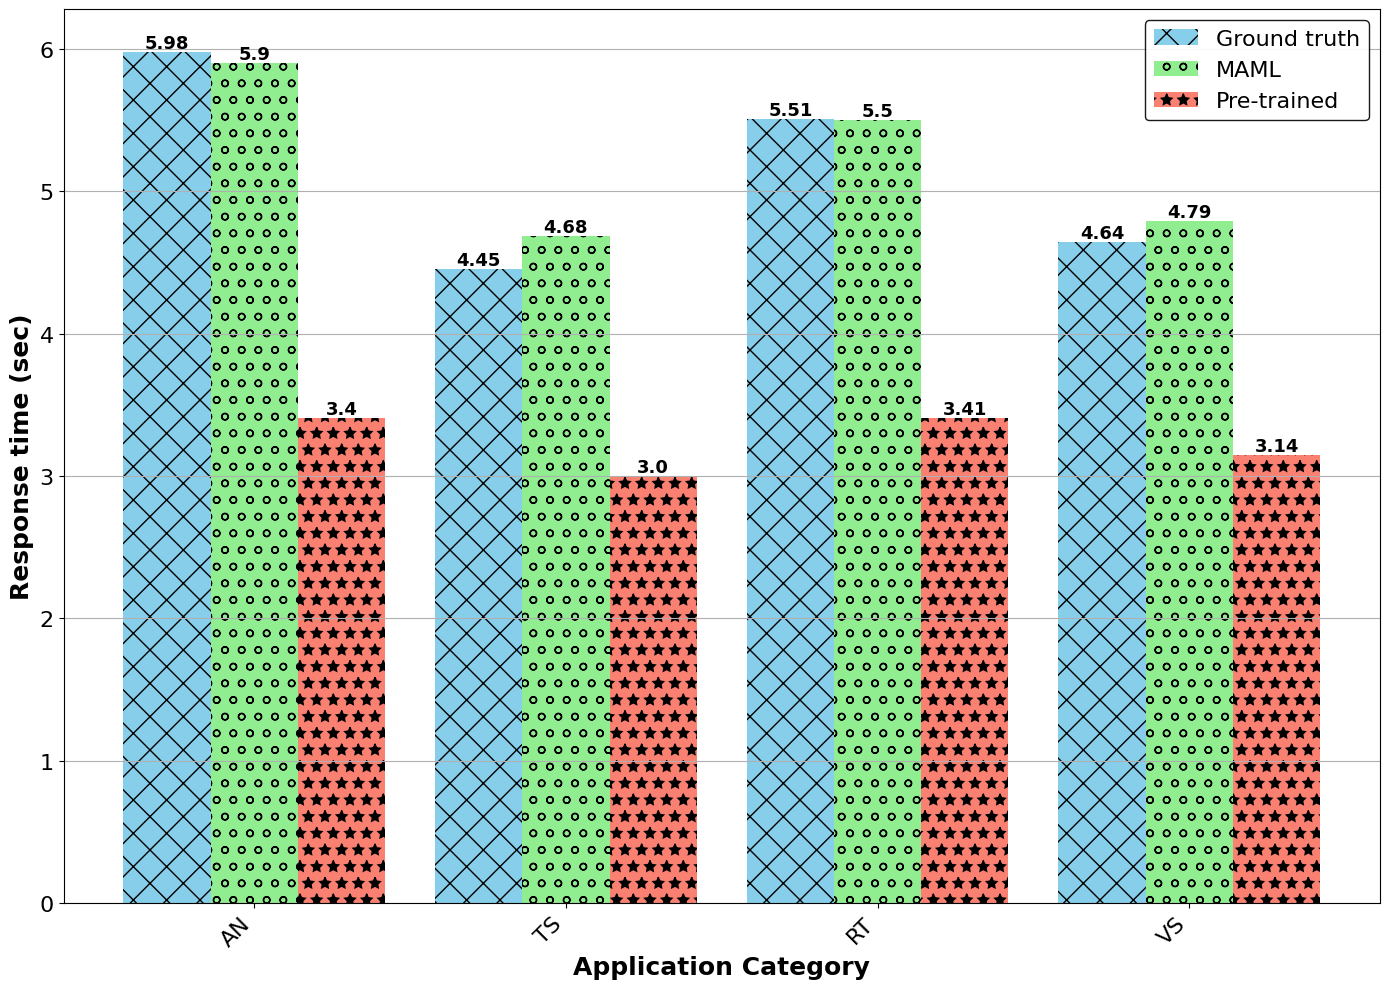

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Set up the figure and axis
fig, ax = plt.subplots(figsize=(14, 10))

# List of columns to plot
columns_to_plot = ['latency', 'Predictions_MAML', 'Predictions_DNN']
colors = ['skyblue', 'lightgreen', 'salmon']  # Define colors for each metric
patterns = ['x', 'o', '*', '/', '\\', '|', '-', '+', 'x', 'o', '*']  # Define patterns for hatching

# Get unique categories in 'applicationCategory'
categories = vis_df['applicationCategory'].unique()
num_categories = len(categories)
bar_width = 0.28  # Width of each bar
index = np.arange(num_categories)  # The label locations

# Plot bars for each category
for i, (column, color) in enumerate(zip(columns_to_plot, colors)):
    values = vis_df.groupby('applicationCategory')[column].mean()  # Aggregating values by 'app' category
    pattern = patterns[i % len(patterns)]  # Use a different pattern for each column

    # Assign custom labels
    if column == 'latency':
        label = 'Ground truth'
    elif column == 'Predictions_MAML':
        label = 'MAML'
    elif column == 'Predictions_DNN':
        label = 'Pre-trained'

    bars = ax.bar(index + i * bar_width, values, bar_width, label=label, color=color, hatch=pattern)

    # Add value annotations on top of each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center', fontsize=13, fontweight='bold')

# Customize axis labels
ax.set_xlabel('Application Category', fontsize=18, fontweight='bold', color='black')
ax.set_ylabel('Response time (sec)', fontsize=18, fontweight='bold', color='black')

# Customize y-axis tick labels font size
ax.tick_params(axis='y', labelsize=16)

# Set titles and legend with customizations
# ax.set_title('Average end-to-end response time between the Ground truth and Adaptation approach values for Each App Category', fontsize=14, fontweight='bold', color='darkred', y=1.02)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=16, color='black')
ax.legend(fontsize=16, title_fontsize='13', loc='upper right', frameon=True, framealpha=0.9, edgecolor='black')

# Customize background colors
# fig.patch.set_facecolor('lightgrey')  # Figure background color
# ax.set_facecolor('whitesmoke')  # Axes background color

# Add horizontal gridlines for easier comparison
ax.yaxis.grid(True)

# Save the plot
filename = 'comparison_plot_customized.png'  # Define the filename and format
fig.savefig(filename, format='png', bbox_inches='tight')  # Save the figure with tight bounding box

# Show the plot
plt.tight_layout()
plt.show()


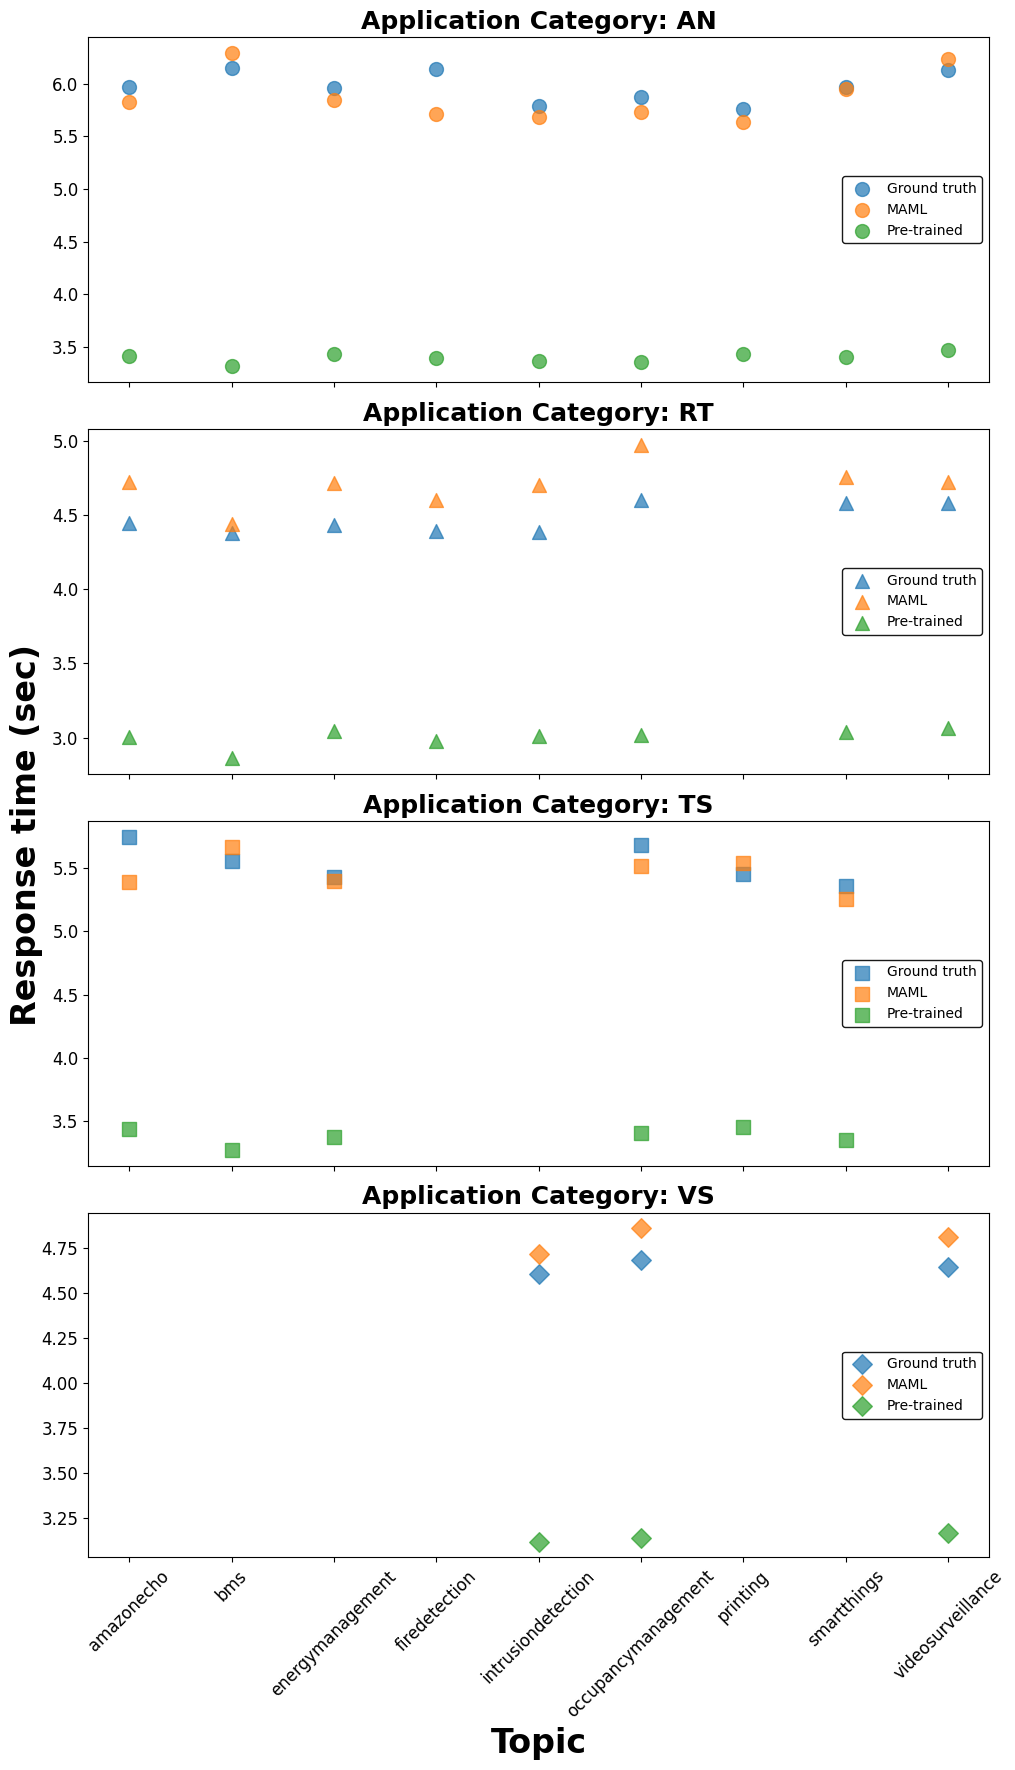

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (replace with your actual DataFrame)
# vis_df = pd.DataFrame({
#     'topic': [1, 1, 2, 2, 1],
#     'applicationCategory': ['A', 'B', 'C', 'D', 'A'],
#     'latency': [10, 20, 15, 25, 30],
#     'Predictions_MAML': [12, 22, 17, 27, 32],
#     'Predictions_DNN': [11, 21, 16, 26, 31]
# })

# Aggregate the mean values for each combination of 'topic' and 'applicationCategory'
average_values = vis_df.groupby(['topic', 'applicationCategory']).agg({
    'latency': 'mean',
    'Predictions_MAML': 'mean',
    'Predictions_DNN': 'mean'
}).reset_index()

# Convert 'topic' to string to handle categorical axis with gaps
average_values['topic'] = average_values['topic'].astype(str)

# Get unique application categories and topics
app_list = average_values['applicationCategory'].unique().tolist()

# Check if 'topic' values can be interpreted as integers
try:
    topics = sorted(set(int(x) for x in average_values['topic']))
except ValueError:
    topics = sorted(average_values['topic'].unique())  # Use default sorting if non-integer values exist

# Define a list of markers
markers = ['o', '^', 's', 'D', 'p', '*', '+', 'x', '|', '_']  # Add more markers as needed

# Create a dictionary to map each category to a marker
category_marker_map = {category: markers[i % len(markers)] for i, category in enumerate(app_list)}

# Set up the figure and axis
fig, axs = plt.subplots(nrows=len(app_list), ncols=1, figsize=(10, 5 * len(app_list)), sharex=True)

# Define the metrics to plot
metrics = ['latency', 'Predictions_MAML', 'Predictions_DNN']
metric_labels = {'latency': 'Ground truth', 'Predictions_MAML': 'MAML', 'Predictions_DNN': 'Pre-trained'}

# Plot each application category
for i, category in enumerate(app_list):
    ax = axs[i]

    # Filter data for the current category
    category_data = average_values[average_values['applicationCategory'] == category]

    # Plot each metric
    for metric in metrics:
        ax.scatter(category_data['topic'], category_data[metric],
                   label=metric_labels[metric],
                   s=100,
                   alpha=0.7,
                   marker=category_marker_map[category])

    # Customize axis labels and title
    ax.set_title(f'Application Category: {category}', fontsize=18, fontweight='bold', color='black')
    ax.legend(fontsize=10, title_fontsize='13', loc='center right', frameon=True, framealpha=0.9, edgecolor='black')

    # Customize y-axis tick labels font size
    ax.tick_params(axis='y', labelsize=12)

# Ensure all x-ticks are shown and in order
for ax in axs:
    ax.set_xticks(topics)  # Set x-ticks to show all topics in order
    ax.set_xticklabels(topics, rotation=45, fontsize=12, color='black')  # Ensure x-tick labels are visible

# Set x-label on the bottom plot
axs[-1].set_xlabel('Topic', fontsize=24, fontweight='bold', color='black')

# Add a centralized y-label
fig.text(0.00, 0.5, 'Response time (sec)', ha='center', va='center', fontsize=24, fontweight='bold', color='black', rotation='vertical')



# Set the title for the entire figure
# fig.suptitle('Average Response Times by Topic and Application Category', fontsize=16, fontweight='bold', color='darkred', y=0.91)

# Adjust layout to make room for the suptitle
plt.tight_layout(rect=[0, 0.03, 1, 0.92])  # Adjust to make room for the suptitle
# Adjust the spacing between subplots and figure borders
# plt.subplots_adjust(left=0.15, right=0.85, top=0.95, bottom=0.05, hspace=0.4)

# Save the plot
filename = 'average_metrics_by_application_category.png'  # Define the filename and format
fig.savefig(filename, format='png', bbox_inches='tight')  # Save the figure with tight bounding box

# Show the plot
plt.show()


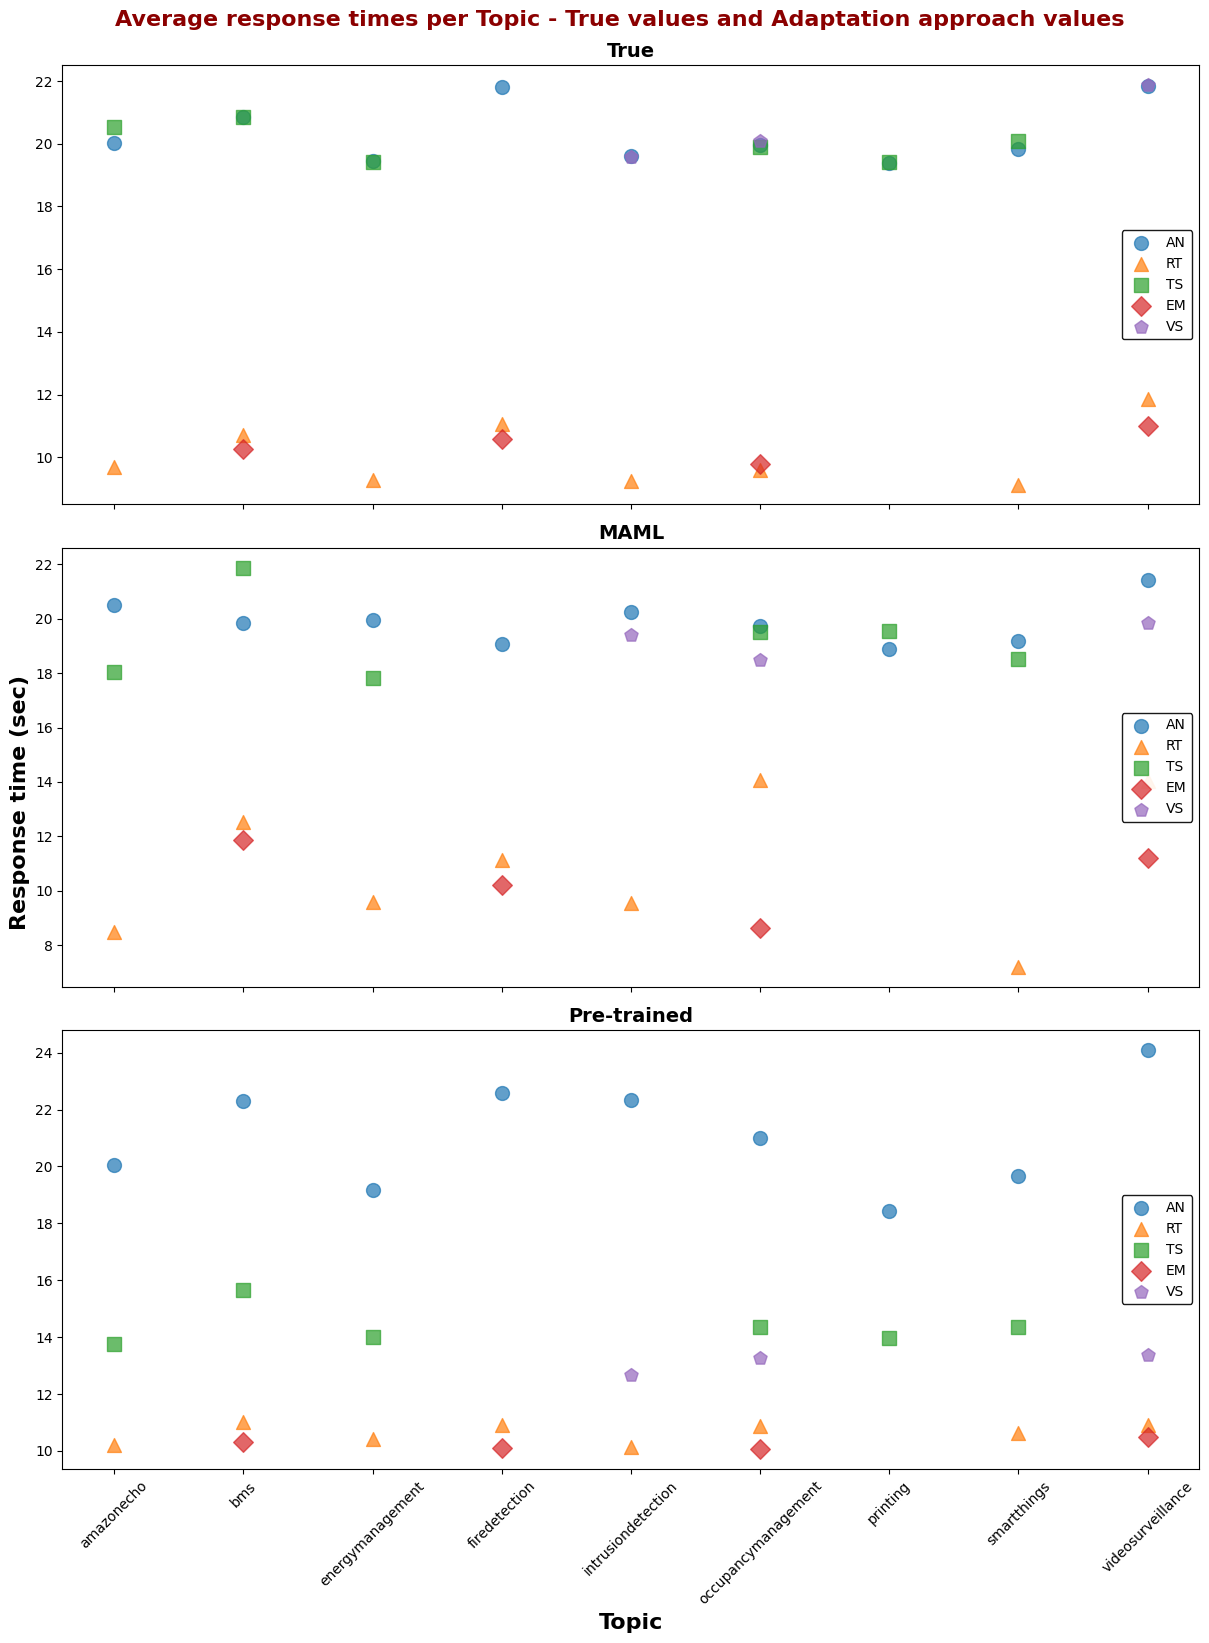

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (replace with your actual DataFrame)
# vis_df = pd.DataFrame({
#     'topic': ['T1', 'T1', 'T2', 'T2', 'T1'],
#     'applicationCategory': ['A', 'B', 'C', 'D', 'A'],
#     'latency': [10, 20, 15, 25, 30],
#     'Predictions_MAML': [12, 22, 17, 27, 32],
#     'Predictions_DNN': [11, 21, 16, 26, 31]
# })

# Aggregate the average values for each combination of 'topic' and 'applicationCategory'
average_values = vis_df.groupby(['topic', 'applicationCategory']).agg({
    'latency': 'mean',
    'Predictions_MAML': 'mean',
    'Predictions_DNN': 'mean'
}).reset_index()

# Get unique application categories
app_list = average_values['applicationCategory'].unique().tolist()

# Define a list of markers
markers = ['o', '^', 's', 'D', 'p', '*', '+', 'x', '|', '_']  # Add more markers as needed

# Create a dictionary to map each category to a marker
category_marker_map = {category: markers[i % len(markers)] for i, category in enumerate(app_list)}

# Set up the figure and axis
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 18), sharex=True)

# Define the metrics to plot
metrics = ['latency', 'Predictions_MAML', 'Predictions_DNN']
titles = ['True', 'MAML', 'Pre-trained']

# Plot each metric in a separate subplot
for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axs[i]
    for category, marker in category_marker_map.items():
        category_data = average_values[average_values['applicationCategory'] == category]
        scatter = ax.scatter(category_data['topic'], category_data[metric],
                            label=category,
                            s=100,
                            alpha=0.7,
                            marker=marker)
    # Customize axis labels and title
    # ax.set_ylabel('Response time (sec)', fontsize=12, fontweight='bold', color='black')
    ax.set_title(title, fontsize=14, fontweight='bold', color='black')
    if i == len(metrics) - 1:  # Only set x-label on the bottom plot
        ax.set_xlabel('Topic', fontsize=16, fontweight='bold', color='black')

    # Customize legend
    # ax.legend(title='Application Category', fontsize=10, title_fontsize='13', loc='upper left', frameon=True, framealpha=0.9, edgecolor='black', bbox_to_anchor=(1, 0.5))
    ax.legend(fontsize=10, title_fontsize='13', loc='center right', frameon=True, framealpha=0.9, edgecolor='black')


# Set the title for the entire figure
fig.suptitle('Average response times per Topic - Ground truth and Adaptation approach values', fontsize=16, fontweight='bold', color='darkred', y=0.94)

# Add a centralized y-label
fig.text(0.00, 0.5, 'Response time (sec)', ha='center', va='center', fontsize=16, fontweight='bold', color='black', rotation='vertical')


# # Customize background colors
# fig.patch.set_facecolor('lightgrey')  # Figure background color
# for ax in axs:
#     ax.set_facecolor('whitesmoke')  # Axes background color

# Rotate x-axis labels and adjust layout
plt.xticks(rotation=45, fontsize=10, color='black')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust to make room for the suptitle

# Save the plot
filename = 'average_metrics_by_topic.png'  # Define the filename and format
fig.savefig(filename, format='png', bbox_inches='tight')  # Save the figure with tight bounding box

# Show the plot
plt.show()


### Extra Visualization for Scaling scenario

In [ ]:
### Extra Visualization for subsczribers
import pandas as pd

data3 = 'combined_sub_metrics_df.csv'
data4 = 'vis_df__sub.csv'

vis_df = pd.read_csv(data4)
comb_df = pd.read_csv(data3)


#Subscribers
test_scenario_case_ids = [80, 100]

# # Filter the DataFrame
filt_comb_df = comb_df[~comb_df['scenario_case'].isin(test_scenario_case_ids)]
# train_df = data[~data['scenario_case'].isin(test_scenario_case_ids)]

In [ ]:
# filt_comb_df.columns

In [ ]:
import pandas as pd

# Assuming filt_comb_df and vis_df are already defined
# Concatenate DataFrames vertically
combined_df = pd.concat([filt_comb_df, vis_df], ignore_index=True, sort=False)

# # Optionally, save the combined DataFrame to a new CSV file
# combined_df.to_csv('combined_df.csv', index=False)

# Print the first few rows of the combined DataFrame
print(combined_df.head(2))


        topic    app applicationCategory   latency  systemBandwidth  \
0  amazonecho  app14                  TS  1.083147              650   
1  amazonecho  app21                  RT  1.115381              650   

   commChannelLossAN  commChannelLossRT  commChannelLossTS  commChannelLossVS  \
0                0.0                0.0                  0               0.01   
1                0.0                0.0                  0               0.01   

   brokerCapacity  ...  messageSize scenario_case  Index  True Values  \
0             100  ...    105869.28            60    NaN          NaN   
1             100  ...    105869.28            60    NaN          NaN   

   Predictions_MAML  MSE Loss_MAML  MAE Loss_MAML  Predictions_DNN  \
0               NaN            NaN            NaN              NaN   
1               NaN            NaN            NaN              NaN   

   MSE Loss_DNN  MAE Loss_DNN  
0           NaN           NaN  
1           NaN           NaN  

[2 rows x 24 c

<ipython-input-53-edab8736b812>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([item.get_text() for item in ax.get_yticklabels()], fontsize=18)  # Increase y-tick label font size


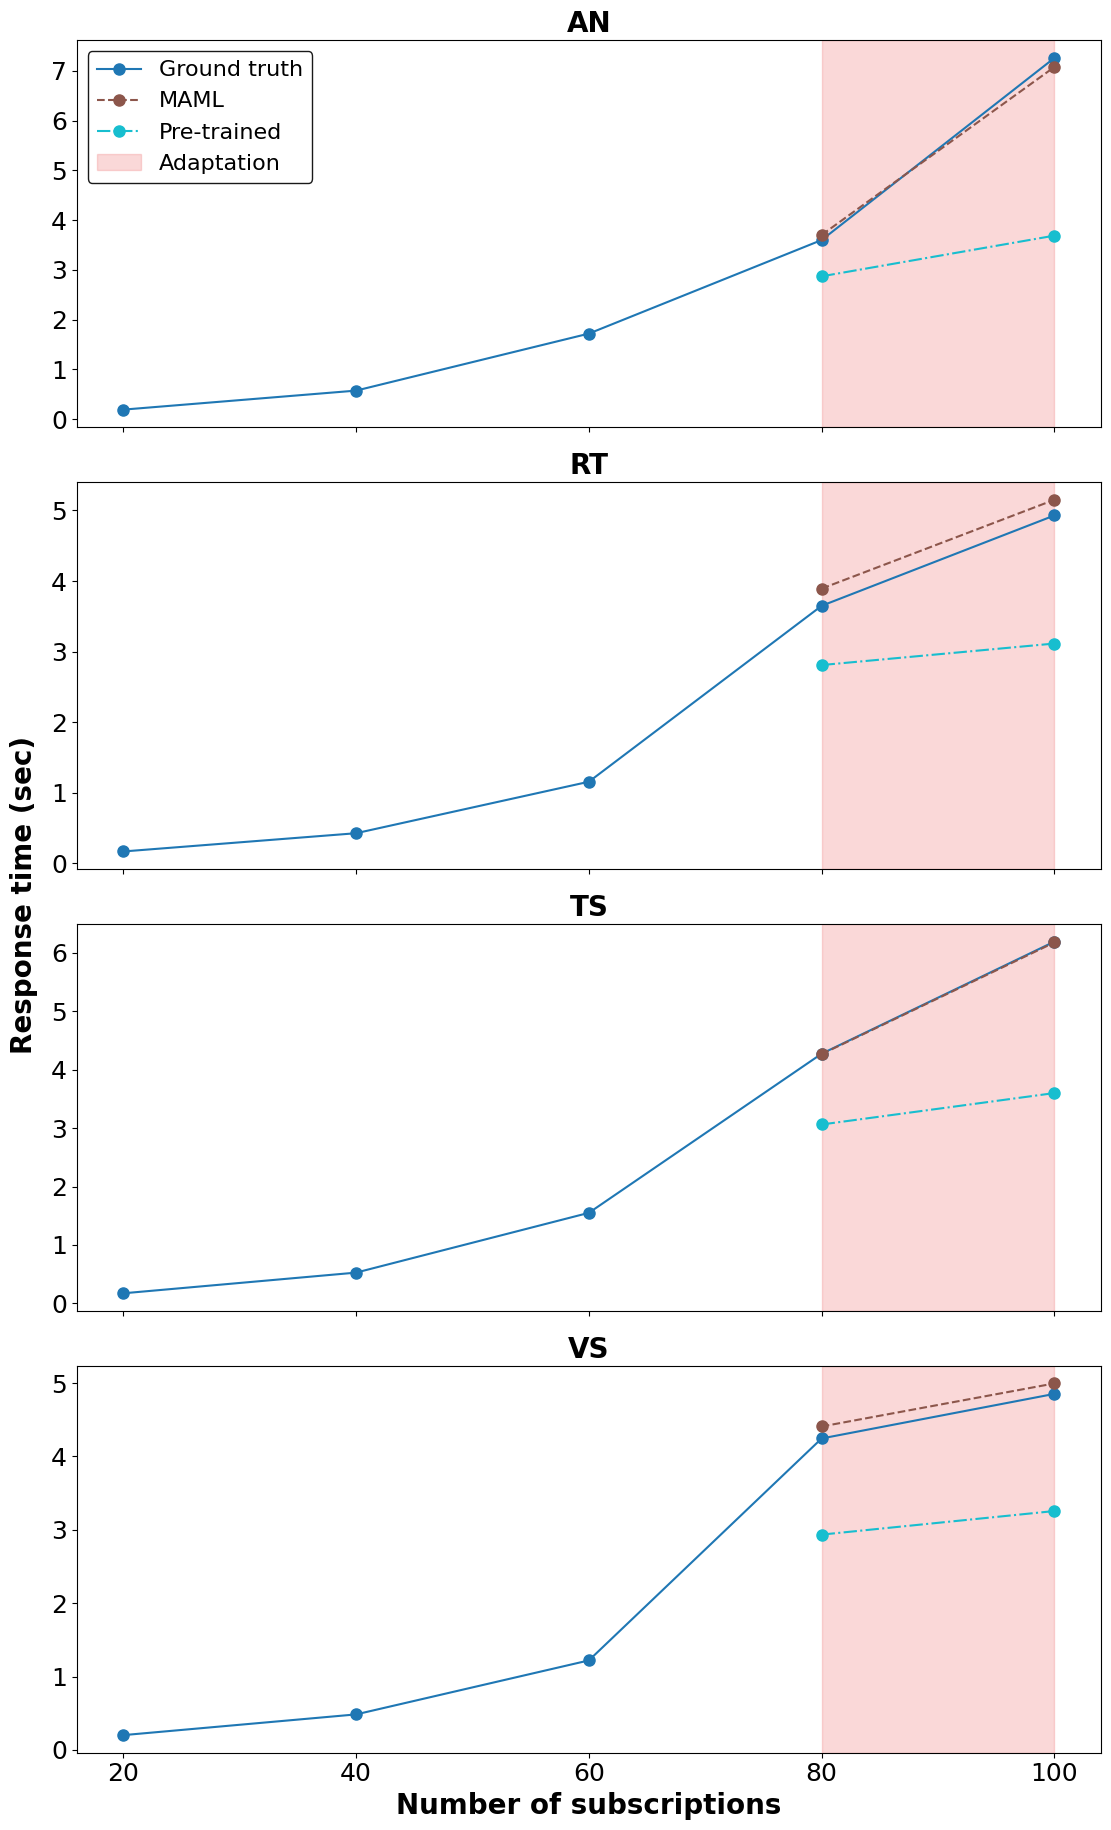

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (replace with your actual DataFrame)
# vis_df = pd.DataFrame({
#     'applicationCategory': ['A', 'A', 'B', 'B', 'C', 'C'],
#     'latency': [10, 15, 20, 25, 30, 35],
#     'Predictions_MAML': [12, 17, 22, 27, 32, 37],
#     'Predictions_DNN': [11, 16, 21, 26, 31, 36],
#     'scenario_case': [70, 80, 90, 100, 110, 120]
# })

# Aggregate the average values for each combination of 'applicationCategory' and 'scenario_case'
average_values = combined_df.groupby(['applicationCategory', 'scenario_case']).agg({
    'latency': 'mean',
    'Predictions_MAML': 'mean',
    'Predictions_DNN': 'mean'
}).reset_index()

# Get unique application categories
app_list = average_values['applicationCategory'].unique().tolist()

# Set up the figure and axis
num_categories = len(app_list)
fig, axs = plt.subplots(nrows=num_categories, ncols=1, figsize=(12, 5 * num_categories), sharex=True)

# Define line styles and colors
line_styles = ['-', '--', '-.', ':']
colors = plt.get_cmap('tab10', 3)  # Get a colormap with enough colors

# Plot each application category in a separate subplot
for i, category in enumerate(app_list):
    ax = axs[i]
    category_data = average_values[average_values['applicationCategory'] == category]

    # Plot each metric with custom labels
    lines = []
    lines.append(ax.plot(category_data['scenario_case'], category_data['latency'],
                         label='Ground truth',  # Custom label
                         linestyle=line_styles[0],
                         color=colors(0),
                         marker='o',
                         markersize=8))

    lines.append(ax.plot(category_data['scenario_case'], category_data['Predictions_MAML'],
                         label='MAML',  # Custom label
                         linestyle=line_styles[1],
                         color=colors(1),
                         marker='o',
                         markersize=8))

    lines.append(ax.plot(category_data['scenario_case'], category_data['Predictions_DNN'],
                         label='Pre-trained',  # Custom label
                         linestyle=line_styles[2],
                         color=colors(2),
                         marker='o',
                         markersize=8))

    # Add shaded regions
    ax.axvspan(80, 100, color='lightcoral', alpha=0.3, label='Adaptation')

    # Customize axis labels and title
    ax.set_title(f'{category}', fontsize=20, fontweight='bold', color='black')
    ax.set_xticks(category_data['scenario_case'])
    ax.set_xticklabels(category_data['scenario_case'], rotation=0, fontsize=18)
    ax.set_yticklabels([item.get_text() for item in ax.get_yticklabels()], fontsize=18)  # Increase y-tick label font size
    ax.grid(False)  # Remove grid lines



    # Add legend to the first subplot
    if i == 0:
        ax.legend(fontsize=16, title_fontsize='13', loc='upper left', frameon=True, framealpha=0.9, edgecolor='black')

# Set the x-label for the bottom subplot
axs[-1].set_xlabel('Number of subscriptions', fontsize=20, fontweight='bold', color='black')

# Add a centralized y-label
fig.text(0.04, 0.5, 'Response time (sec)', ha='center', va='center', fontsize=20, fontweight='bold', color='black', rotation='vertical')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0.03, 0.95, 0.95])  # Adjust to make room for the suptitle


# Set the title for the entire figure
# fig.suptitle('Average response times per Subscription for Each Application Category', fontsize=16, fontweight='bold', color='darkred', y=0.96)

# Save the plot
filename = 'metrics_per_scenario_case_by_category.png'  # Define the filename and format
fig.savefig(filename, format='png', bbox_inches='tight')  # Save the figure with tight bounding box

# Show the plot
plt.show()
